In [108]:
import os
import sys
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import portion as P
import itertools as it
import csv
from pprint import pprint
from pytictoc import TicToc
from tqdm import tqdm
import traceback
import math
import matplotlib.colors as mcolors
from statistics import mean

import pandas as pd
import numpy as np
import datetime as dt
import os
import matplotlib
import matplotlib.pyplot as plt
import sys
import socket
import itertools
from pprint import pprint

# ******************************* User Settings *******************************
database = "/home/wmnlab/D/database/"
# date = "2022-12-20"
dates = [
         "2023-02-04", 
         "2023-02-04#1",
         "2023-02-04#2",
         ]
devices = sorted([
    # "sm00",
    # "sm01",
    # "sm02",
    # "sm03",
    # "sm04",
    # "sm05",
    # "sm06",
    # "sm07",
    # "sm08",
    # "qc00",
    "qc01",
    "qc02",
    "qc03",
])
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
            # If the list is None, it will not list as directories.
            # If the list is empty, it will list all directories in the current directory by default.
            # If the number of experiment times != the length of existing directories of list, it would trigger warning and skip the directory.
    "_Bandlock_Udp_B3_B7_B8_RM500Q": (2, []),
    "_Bandlock_Udp_all_RM500Q": (2, []),
}

LENGTH = 250
DATA_RATE = 1000e3  # bits-per-second
PKT_RATE = DATA_RATE / LENGTH / 8  # packets-per-second
print("packet_rate (pps):", PKT_RATE, "\n")
# *****************************************************************************

packet_rate (pps): 500.0 



In [109]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 0}

matplotlib.rc('font', **font)
matplotlib.rcParams.update({'font.size': 72})
matplotlib.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': True,
          'axes.grid.axis': 'both',
          'axes.grid

In [110]:
mask = np.ones((3,3))
for i in range(0,3):
    for j in range(0,i+1):
        mask[i][j] = False  # 掩蓋掉上面的三角形

In [111]:
# ****************************** Utils Functions ******************************
def makedir(dirpath, mode=0):  # mode=1: show message; mode=0: hide message
    if os.path.isdir(dirpath):
        if mode:
            print("mkdir: cannot create directory '{}': directory has already existed.".format(dirpath))
        return
    ### recursively make directory
    _temp = []
    while not os.path.isdir(dirpath):
        _temp.append(dirpath)
        dirpath = os.path.dirname(dirpath)
    while _temp:
        dirpath = _temp.pop()
        print("mkdir", dirpath)
        os.mkdir(dirpath)

def interp(x, y, ratio):
    """
    Interpolation

    Args:
        x, y (datetime.datetime): x < y
        ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
    Returns:
        (datetime.datetime): breakpoint of interpolation
    """
    return x + (y - x) * ratio

def is_disjoint(set1, set2):
    """
    Check if two sets are disjoint.
    """
    return (set1 & set2).empty

def pairwise_disjoint(set_list):
    """
    Check if all sets in the list are pairwise disjoint.
    """
    pair_list = list(it.combinations(set_list, 2))
    for item in pair_list:
        if not is_disjoint(item[0], item[1]):
            return False
    return True

def union_all(set_list):
    """
    Union all sets in the list.
    """
    _temp = P.empty()
    for _set in set_list:
        _temp = _temp | _set
    return _temp

def get_length(intervals):
    """
    Get total length of a set of intervals.
    """
    if intervals.empty:
        return 0
    sum = 0
    for s in intervals:
        sum += (s.upper - s.lower) / dt.timedelta(seconds=1)
    return round(sum, 3)
# *****************************************************************************

In [112]:
handover_types_0   = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
link_failure_types = "scg_failure,radio_link_failure,nas_recovery".split(',')
handover_types_1   = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2   = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
# print(handover_types_0)
# print(link_failure_types)
# print(handover_types_1)
# print(handover_types_2)

handover_types = [ *handover_types_0, *link_failure_types ]

# ****************************** Classify Function ******************************
def get_ho_interval(hodf, types=handover_types, sstime=(dt.datetime.min, dt.datetime.max), secs=(1, 3), ratio=0.5):
    """
    Get intervals of each event type.

    Args:
        hodf (pandas.Dataframe): dataframe import from "./data/diag_log_ho-info.csv"
        rxdf (pandas.Dataframe): dataframe import from "./data/udp_dnlk_latency.csv" or "./data/udp_uplk_latency.csv"
        lodf (pandas.Dataframe): dataframe import from "./data/udp_dnlk_loss_timestamp.csv" or "./data/udp_uplk_loss_timestamp.csv"
        types (list): names of event types.
        setime (tuple): (start time, end time) of an experiment.
        secs (tuple): size of window to specify (in seconds); the former is for successful ho, the latter is for failed ho.
        ratio (float): a decimal numeral in a range [0, 1], to decide the breakpoint of interpolation when overlap occurs; set ratio to None if no need for overlap checking.

    Returns:
        before_event_intervals (portion.interval.Interval)
        during_events_intervals (portion.interval.Interval)
        after_events_intervals (portion.interval.Interval)
    """
    def trim(timestamp):
        """
        Avoid an interval exceeds the boundary of experiment stard/end time.
        """
        return min(max(timestamp, sstime[0]), sstime[1])
    
    column_names = []
    for type_name in types:
        column_names += ["before_{}".format(type_name), "during_{}".format(type_name), "after_{}".format(type_name)]

    event_intvl = dict.fromkeys(column_names, P.empty())
    event_dur = dict.fromkeys(column_names, "")
    # event_occur = dict.fromkeys(column_names, 0)
    # loss_num = dict.fromkeys(column_names, "")
    # pkt_num = dict.fromkeys(column_names, "")
    # t_loss_num = dict.fromkeys(column_names, 0)
    # t_pkt_num = dict.fromkeys(column_names, 0)

    # j, k = 0, 0
    # lots = lodf["Timestamp"].array
    # rxts = rxdf["Timestamp"].array
    # anomaly_check = []
    # overlaps_num = 0
    # included_num = 0

    # print(secs[0], secs[1], "seconds") if secs[0] != secs[1] else print(secs[0], "seconds")
    # print("---------------------------------------------------------")
    for i in range(len(hodf)):
        _now = hodf.iloc[i]
        _prior = hodf.iloc[i-1] if i != 0 else None
        _post = hodf.iloc[i+1] if i != len(hodf)-1 else None
        if i != 0 and _now["handoff_state"] == "trigger" and _prior["handoff_state"] == "start":
            # print(i, _now["Timestamp"], "'{}' is included during '{}'.".format(_now["handoff_type"], _prior["handoff_type"]))
            # included_num += 1
            # anomaly_check.append((_now["Timestamp"], _now["handoff_type"], _prior["handoff_type"]))
            continue
        if _now["handoff_state"] != "end":  # "start" or "trigger"
            ### prior
            _start = _now
            C = _start["Timestamp"] - dt.timedelta(seconds=secs[0]) if _start["handoff_state"] == "start" else _start["Timestamp"] - dt.timedelta(seconds=secs[1])
            D = _start["Timestamp"]
            prior_interval = P.closedopen(trim(C), trim(D))
            if ratio != None and i != 0:
                A = _prior["Timestamp"]
                B = _prior["Timestamp"] + dt.timedelta(seconds=secs[0]) if _prior["handoff_state"] == "end" else _prior["Timestamp"] + dt.timedelta(seconds=secs[1])
                if P.openclosed(A, B).overlaps(prior_interval):
                    # print(i, _now["Timestamp"], "'{}' overlaps with the previous '{}' for {} seconds.".format(_start["handoff_type"], _prior["handoff_type"], get_length(P.openclosed(A, B) & prior_interval)))
                    # overlaps_num += 1
                    # print(get_length(P.openclosed(A, B)))
                    bkp = interp(C, B, ratio)
                    bkp = max(bkp, A)  # to avoid the breakpoint overlaps the previous event's duration
                    # bkp = min(max(bkp, A), D)  # 我不侵犯到其他任何人，代表其他人也不會侵犯到我！
                    ## blindly set as open inverval is fine, but may sometimes miss one point.
                    prior_interval = P.closedopen(trim(bkp), trim(D))
                    if A in prior_interval:
                        prior_interval = P.open(trim(bkp), trim(D))
        if _now["handoff_state"] != "start":  # "end" or "trigger"
            ### middle
            middle_interval = P.closed(trim(_start["Timestamp"]), trim(_now["Timestamp"]))
            ### post
            C = _now["Timestamp"]
            D = _now["Timestamp"] + dt.timedelta(seconds=secs[0]) if _now["handoff_state"] == "end" else _now["Timestamp"] + dt.timedelta(seconds=secs[1])
            post_interval = P.openclosed(trim(C), trim(D))
            if ratio != None and i != len(hodf)-1:
                A = _post["Timestamp"] - dt.timedelta(seconds=secs[0]) if _post["handoff_state"] == "start" else _post["Timestamp"] - dt.timedelta(seconds=secs[1])
                B = _post["Timestamp"]
                if P.closedopen(A, B).overlaps(post_interval):
                    # print(i, _now["Timestamp"], "'{}' overlaps with the following '{}' for {} seconds.".format(_now["handoff_type"], _post["handoff_type"], get_length(P.closedopen(A, B) & post_interval)))
                    # overlaps_num += 1
                    # print(get_length(P.closedopen(A, B)))
                    bkp = interp(A, D, ratio)
                    bkp = min(bkp, B)  # to avoid the breakpoint overlaps the following event's duration
                    # bkp = max(min(bkp, B), C)  # 我不侵犯到其他任何人，代表其他人也不會侵犯到我！
                    post_interval = P.open(trim(C), trim(bkp))
            
            type_name = _now["handoff_type"]
            ## before_event_intervals
            event_name = "before_{}".format(type_name)
            event_intvl[event_name] = event_intvl[event_name] | prior_interval
            ## during_event_intervals
            event_name = "during_{}".format(type_name)
            event_intvl[event_name] = event_intvl[event_name] | middle_interval
            ## after_event_intervals
            event_name = "after_{}".format(type_name)
            event_intvl[event_name] = event_intvl[event_name] | post_interval

            # _lotmp = dict.fromkeys(["before", "during", "after"], 0)
            # _rxtmp = dict.fromkeys(["before", "during", "after"], 0)
            # while j < len(lots):
            #     if lots[j] in prior_interval:
            #         _lotmp["before"] += 1
            #     elif lots[j] in middle_interval:
            #         _lotmp["during"] += 1
            #     elif lots[j] in post_interval:
            #         _lotmp["after"] += 1
            #     elif lots[j] >= max(prior_interval.upper, middle_interval.upper, post_interval.upper):
            #         break
            #     j += 1
            # while k < len(rxts):
            #     if rxts[k] in prior_interval:
            #         _rxtmp["before"] += 1
            #     elif rxts[k] in middle_interval:
            #         _rxtmp["during"] += 1
            #     elif rxts[k] in post_interval:
            #         _rxtmp["after"] += 1
            #     elif rxts[k] >= max(prior_interval.upper, middle_interval.upper, post_interval.upper):
            #         break
            #     k += 1

            # for prefix in ["before", "during", "after"]:
            #     event_name = "{}_{}".format(prefix, type_name)
            #     event_occur[event_name] += 1
            #     loss_num[event_name] = '@'.join([loss_num[event_name], str(_lotmp[prefix])]) if loss_num[event_name] else str(_lotmp[prefix])
            #     pkt_num[event_name] = '@'.join([pkt_num[event_name], str(_lotmp[prefix]+_rxtmp[prefix])]) if pkt_num[event_name] else str(_lotmp[prefix]+_rxtmp[prefix])
            #     t_loss_num[event_name] += _lotmp[prefix]
            #     t_pkt_num[event_name] += (_lotmp[prefix]+_rxtmp[prefix])
            
    #         event_dur["before_{}".format(type_name)] = '@'.join([event_dur["before_{}".format(type_name)], str(get_length(prior_interval))]) if event_dur["before_{}".format(type_name)] else str(get_length(prior_interval))
    #         event_dur["during_{}".format(type_name)] = '@'.join([event_dur["during_{}".format(type_name)], str(get_length(middle_interval))]) if event_dur["during_{}".format(type_name)] else str(get_length(middle_interval))
    #         event_dur["after_{}".format(type_name)] = '@'.join([event_dur["after_{}".format(type_name)], str(get_length(post_interval))]) if event_dur["after_{}".format(type_name)] else str(get_length(post_interval))
    
    # t_duration = dict(zip(column_names, [get_length(item) for item in event_intvl.values()]))

    # t_ho_num = sum(hodf["handoff_state"] != "end")
    # overlaps_num = overlaps_num // 2
    # overlaps_ratio = round(overlaps_num / (t_ho_num + 1e-9) * 100, 2)
    # print(overlaps_num, included_num, t_ho_num)
    # print("overlaps ratio: {}(%)".format(overlaps_ratio))

    # ## overall
    # t_duration["overall"] = (sstime[1] - sstime[0]).total_seconds() if sstime[1] > sstime[0] else 0
    # t_loss_num["overall"] = len(lots)
    # t_pkt_num["overall"] = len(lots) + len(rxts)
    # ## unstable
    # t_duration["unstable"] = sum([t_duration[key] for key in column_names[:-3]])
    # t_loss_num["unstable"] = sum([t_loss_num[key] for key in column_names[:-3]])
    # t_pkt_num["unstable"] = sum([t_pkt_num[key] for key in column_names[:-3]])
    # ## stable
    # t_duration["stable"] = t_duration["overall"] - t_duration["unstable"]
    # t_loss_num["stable"] = t_loss_num["overall"] - t_loss_num["unstable"]
    # t_pkt_num["stable"] = t_pkt_num["overall"] - t_pkt_num["unstable"] 
    
    # lodict = {  "event_occur" : event_occur,
    #             "event_dur" : event_dur,
    #             "loss_num" : loss_num,
    #             "pkt_num" : pkt_num,
    #             "t_duration" : t_duration,
    #             "t_loss_num" : t_loss_num,
    #             "t_pkt_num" : t_pkt_num,
    #             # "event_intvl" : event_intvl,
    #         }
    
    # return event_intvl, event_occur, event_dur, loss_num, pkt_num, t_duration, t_loss_num, t_pkt_num, anomaly_check
    return event_intvl
# *****************************************************************************

In [113]:
hodf1 = pd.read_csv("/home/wmnlab/D/database/2023-02-04/_Bandlock_Udp_B3_B7_B8_RM500Q/qc01/#01/data/diag_log_ho-info_new.csv")
hodf1["Timestamp"] = pd.to_datetime(hodf1["Timestamp"])
hodf2 = pd.read_csv("/home/wmnlab/D/database/2023-02-04/_Bandlock_Udp_B3_B7_B8_RM500Q/qc02/#01/data/diag_log_ho-info_new.csv")
hodf2["Timestamp"] = pd.to_datetime(hodf2["Timestamp"])

event_intvl_1 = get_ho_interval(hodf1, secs=(1, 3))
event_intvl_2 = get_ho_interval(hodf2, secs=(1, 3))

ho_intervals_1 = union_all(event_intvl_1.values())
ho_intervals_2 = union_all(event_intvl_2.values())
print(get_length(ho_intervals_1), "seconds")
print(get_length(ho_intervals_2), "seconds")
print(get_length(ho_intervals_1 | ho_intervals_2), "seconds")
print(get_length(ho_intervals_1 & ho_intervals_2), "seconds")
print(round(get_length(ho_intervals_1 & ho_intervals_2) / (get_length(ho_intervals_1 | ho_intervals_2) + 1e-9) * 100, 3), "%")

76.303 seconds
85.467 seconds
118.254 seconds
43.516 seconds
36.799 %


# B3.B7.B8

In [114]:
database = "/home/wmnlab/D/database/"
dates = [
         "2023-02-04", 
         "2023-02-04#1",
        #  "2023-02-04#2",
         ]
devices = sorted([
    # "sm00",
    # "sm01",
    # "sm02",
    # "sm03",
    # "sm04",
    # "sm05",
    # "sm06",
    # "sm07",
    # "sm08",
    # "qc00",
    "qc01",
    "qc02",
    "qc03",
])
schemes = [
    "B3",
    "B7",
    "B8",
    # "All@qc01",
    # "All@qc02",
    # "All@qc03",
]
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
            # If the list is None, it will not list as directories.
            # If the list is empty, it will list all directories in the current directory by default.
            # If the number of experiment times != the length of existing directories of list, it would trigger warning and skip the directory.
    "_Bandlock_Udp_B3_B7_B8_RM500Q": (2, ["#01", "#02"]),
    # "_Bandlock_Udp_all_RM500Q": (2, ["#01", "#02"]),
    # "_Bandlock_Udp_B3_B7_B8_RM500Q": (1, ["#01",]),
}

mat = []
for i in range(3):
    # mat.append([])
    for j in range(3):
        if i == j:
            # print(i, end=' ')
            print(schemes[i], end=' ')
            # mat[i].append(dfm[f'lost.{schemes[i]}'])
        elif i < j:
            # print((i, j), end=' ')
            print(f"{schemes[i]}.{schemes[j]}", end=' ')
            # mat[i].append(dfm[f'lost.{schemes[i]}.{schemes[j]}'])
        else:
            print(0, end=' ')
            # mat[i].append(0)
    print()

B3 B3.B7 B3.B8 
0 B7 B7.B8 
0 0 B8 


### Similarity

In [115]:
mat = []
for i in range(3):
    mat.append([])
    for j in range(3):
        mat[i].append([])
print(mat)

for date in dates:
    for expr, (times, traces) in exps.items():
        for trace in traces:
            target_dir = os.path.join(database, date, expr, "combo", trace)
            makedir(target_dir)
            print("------------------------------------------")
            print(date, expr, trace)  
            print("------------------------------------------")
            t = TicToc()
            t.tic()
            dfs = []
            event_intv = []
            ho_intervals = []
            for i, (dev, scheme) in enumerate(zip(devices, schemes)):
                source_dir = os.path.join(database, date, expr, dev, trace, "data")
                dfs.append(pd.read_csv(os.path.join(source_dir, f"diag_log_ho-info_new.csv")))
                dfs[i]["Timestamp"] = pd.to_datetime(dfs[i]["Timestamp"])
            ### TODO 1
            for i, (dev, scheme) in enumerate(zip(devices, schemes)):
                event_intv.append(get_ho_interval(dfs[i], secs=(0, 1)))
                ho_intervals.append(union_all(event_intv[i].values()))
                print(get_length(ho_intervals[i]), "seconds")
            ### TODO 2
            # mat = []
            for i in range(3):
                # mat.append([])
                for j in range(3):
                    # mat[i].append([])
                    if i == j:
                        # print(i, end=' ')
                        # print(schemes[i], end=' ')
                        # mat[i].append(100)
                        mat[i][j].append(100)
                    elif i < j:
                        # print((i, j), end=' ')
                        # print(f"{schemes[i]}.{schemes[j]}", end=' ')
                        # mat[i].append(round(get_length(ho_intervals[i] & ho_intervals[j]) / (get_length(ho_intervals[i] | ho_intervals[j]) + 1e-9) * 100, 3))
                        mat[i][j].append(round(get_length(ho_intervals[i] & ho_intervals[j]) / (get_length(ho_intervals[i] | ho_intervals[j]) + 1e-9) * 100, 3))
                    else:
                        # print(0, end=' ')
                        # mat[i].append(0)
                        mat[i][j].append(0)
                # print()
            # pprint(mat)
            ### TODO END
print()

for i in range(3):
    for j in range(3):
        mat[i][j] = mean(mat[i][j])
print(mat)

[[[], [], []], [[], [], []], [[], [], []]]
------------------------------------------
2023-02-04 _Bandlock_Udp_B3_B7_B8_RM500Q #01
------------------------------------------
2.921 seconds
1.213 seconds
4.835 seconds
------------------------------------------
2023-02-04 _Bandlock_Udp_B3_B7_B8_RM500Q #02
------------------------------------------
2.383 seconds
4.38 seconds
0.643 seconds
------------------------------------------
2023-02-04#1 _Bandlock_Udp_B3_B7_B8_RM500Q #01
------------------------------------------
2.872 seconds
4.958 seconds
2.852 seconds
------------------------------------------
2023-02-04#1 _Bandlock_Udp_B3_B7_B8_RM500Q #02
------------------------------------------
2.853 seconds
8.769 seconds
2.958 seconds

[[100, 3.6719999999999997, 0.9934999999999999], [0, 100, 0.72325], [0, 0, 100]]


### heatmap

[[100, 3.6719999999999997, 0.9934999999999999], [0, 100, 0.72325], [0, 0, 100]]


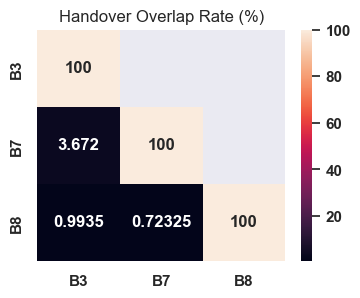

In [116]:
print(mat)
data = mat

import seaborn as sns; sns.set_theme()
fig, ax = plt.subplots(figsize=(4, 3))
axis_labels = schemes
plt.title("Handover Overlap Rate (%)")
ax = sns.heatmap(np.array(data).T, xticklabels=axis_labels, yticklabels=axis_labels, mask=mask, annot=True, fmt=".5g")
# sns.set(rc = {'figure.figsize':(10,2)})

# All

In [117]:
database = "/home/wmnlab/D/database/"
dates = [
        #  "2023-02-04", 
        #  "2023-02-04#1",
         "2023-02-04#2",
         ]
devices = sorted([
    # "sm00",
    # "sm01",
    # "sm02",
    # "sm03",
    # "sm04",
    # "sm05",
    # "sm06",
    # "sm07",
    # "sm08",
    # "qc00",
    "qc01",
    "qc02",
    "qc03",
])
schemes = [
    # "B3",
    # "B7",
    # "B8",
    "All@qc01",
    "All@qc02",
    "All@qc03",
]
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
            # If the list is None, it will not list as directories.
            # If the list is empty, it will list all directories in the current directory by default.
            # If the number of experiment times != the length of existing directories of list, it would trigger warning and skip the directory.
    # "_Bandlock_Udp_B3_B7_B8_RM500Q": (2, ["#01", "#02"]),
    "_Bandlock_Udp_all_RM500Q": (2, ["#01", "#02"]),
    # "_Bandlock_Udp_B3_B7_B8_RM500Q": (1, ["#01",]),
}

mat = []
for i in range(3):
    # mat.append([])
    for j in range(3):
        if i == j:
            # print(i, end=' ')
            print(schemes[i], end=' ')
            # mat[i].append(dfm[f'lost.{schemes[i]}'])
        elif i < j:
            # print((i, j), end=' ')
            print(f"{schemes[i]}.{schemes[j]}", end=' ')
            # mat[i].append(dfm[f'lost.{schemes[i]}.{schemes[j]}'])
        else:
            print(0, end=' ')
            # mat[i].append(0)
    print()

All@qc01 All@qc01.All@qc02 All@qc01.All@qc03 
0 All@qc02 All@qc02.All@qc03 
0 0 All@qc03 


### Similarity

In [118]:
mat = []
for i in range(3):
    mat.append([])
    for j in range(3):
        mat[i].append([])
print(mat)

for date in dates:
    for expr, (times, traces) in exps.items():
        for trace in traces:
            target_dir = os.path.join(database, date, expr, "combo", trace)
            makedir(target_dir)
            print("------------------------------------------")
            print(date, expr, trace)  
            print("------------------------------------------")
            t = TicToc()
            t.tic()
            dfs = []
            event_intv = []
            ho_intervals = []
            for i, (dev, scheme) in enumerate(zip(devices, schemes)):
                source_dir = os.path.join(database, date, expr, dev, trace, "data")
                dfs.append(pd.read_csv(os.path.join(source_dir, f"diag_log_ho-info_new.csv")))
                dfs[i]["Timestamp"] = pd.to_datetime(dfs[i]["Timestamp"])
            ### TODO 1
            for i, (dev, scheme) in enumerate(zip(devices, schemes)):
                event_intv.append(get_ho_interval(dfs[i], secs=(0, 1)))
                ho_intervals.append(union_all(event_intv[i].values()))
                print(get_length(ho_intervals[i]), "seconds")
            ### TODO 2
            # mat = []
            for i in range(3):
                # mat.append([])
                for j in range(3):
                    # mat[i].append([])
                    if i == j:
                        # print(i, end=' ')
                        # print(schemes[i], end=' ')
                        # mat[i].append(100)
                        mat[i][j].append(100)
                    elif i < j:
                        # print((i, j), end=' ')
                        # print(f"{schemes[i]}.{schemes[j]}", end=' ')
                        # mat[i].append(round(get_length(ho_intervals[i] & ho_intervals[j]) / (get_length(ho_intervals[i] | ho_intervals[j]) + 1e-9) * 100, 3))
                        mat[i][j].append(round(get_length(ho_intervals[i] & ho_intervals[j]) / (get_length(ho_intervals[i] | ho_intervals[j]) + 1e-9) * 100, 3))
                    else:
                        # print(0, end=' ')
                        # mat[i].append(0)
                        mat[i][j].append(0)
                # print()
            # pprint(mat)
            ### TODO END
print()

for i in range(3):
    for j in range(3):
        mat[i][j] = mean(mat[i][j])
print(mat)

[[[], [], []], [[], [], []], [[], [], []]]
------------------------------------------
2023-02-04#2 _Bandlock_Udp_all_RM500Q #01
------------------------------------------
3.197 seconds
5.103 seconds
5.109 seconds
------------------------------------------
2023-02-04#2 _Bandlock_Udp_all_RM500Q #02
------------------------------------------
8.831 seconds
11.093 seconds
6.974 seconds

[[100, 9.544500000000001, 0.605], [0, 100, 10.146], [0, 0, 100]]


### heatmap

[[100, 9.544500000000001, 0.605], [0, 100, 10.146], [0, 0, 100]]


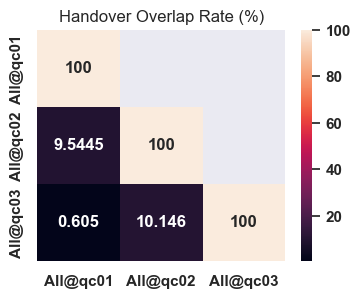

In [119]:
print(mat)
data = mat

import seaborn as sns; sns.set_theme()
fig, ax = plt.subplots(figsize=(4, 3))
axis_labels = schemes
plt.title("Handover Overlap Rate (%)")
ax = sns.heatmap(np.array(data).T, xticklabels=axis_labels, yticklabels=axis_labels, mask=mask, annot=True, fmt=".5g")
# sns.set(rc = {'figure.figsize':(10,2)})